## IMPORTING LIBRARIES

In [26]:
import numpy as np 
import pandas as pd
import cv2 
from mtcnn import MTCNN
from matplotlib import pyplot as plt
from keras.models import load_model
from PIL import Image
import os
import joblib



## A FUNCTION FOR EXTRACTING A SINGLE FACE FROM AN IMAGE

In [3]:

def extract_face(filename, required_size=(160, 160)):
    
    image = Image.open(filename)
   
    image = image.convert('RGB')
  
    pixels = np.asarray(image)
    
    detector = MTCNN()
    
    results = detector.detect_faces(pixels)
    
    x1, y1, width, height = results[0]['box']
    
    x1, y1 = abs(x1), abs(y1)
    
    x2, y2 = x1 + width, y1 + height
    
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

## FUNCTION TO EXTRACT MULTIPLE FACES FROM AN IMAGE

In [35]:
def extract_faces(filename, required_size=(160, 160)):
    
    image = Image.open(filename)
    
    image = image.convert('RGB')
   
    pixels = np.asarray(image)
    
    detector = MTCNN(min_face_size=70, steps_threshold=[0.6, 0.7, 0.7])


    results = detector.detect_faces(pixels)
    
    faces = []
    
    # Loop over the detected faces and extract each face
    for result in results:
        # Extract the bounding box of the face
        x1, y1, width, height = result['box']
        # Deal with negative pixel index
        x1, y1 = abs(x1), abs(y1)
        x2, y2 = x1 + width, y1 + height
        # Extract the face
        face = pixels[y1:y2, x1:x2]
        # Resize the face to the required size
        image = Image.fromarray(face)
        image = image.resize(required_size)
        face_array = np.asarray(image)
        # Append the extracted face to the list
        faces.append(face_array)
    
    return faces

In [5]:
def load_face(dir):
    faces = list()
    # enumerate files
    for filename in os.listdir(dir):
        path = dir + filename
        face = extract_face(path)
        faces.append(face)
    return faces



        

## LOADING THE TRANING DATASET AND SAVING IT BY COMPRESSING IT 

In [6]:
def load_dataset(dir):
    # list for faces and labels
    X, y = list(), list()
    for subdir in os.listdir(dir):
        path = dir + subdir + '/'
        faces = load_face(path)
        labels = [subdir for i in range(len(faces))]
        print("loaded %d sample for class: %s" % (len(faces),subdir) ) # print progress
        X.extend(faces)
        y.extend(labels)
    return np.asarray(X), np.asarray(y)


# load train dataset
trainX, trainy = load_dataset('data/train/')
print(trainX.shape, trainy.shape)


1/1 [==============================] - 0s 127ms/step
loaded 5 sample for class: Ayaan
1/1 [==============================] - 0s 129ms/step
loaded 5 sample for class: ben_afflek
3/3 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 128ms/step
loaded 5 sample for class: elton_john
1/1 [==============================] - 0s 136ms/step
loaded 5 sample for class: jerry_seinfeld
1/1 [==============================] - 0s 141ms/step
loaded 5 sample for class: madonna
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 123ms/step
loaded 5 sample for class: mindy_kaling
1/1 [==============================] - 0s 174ms/step
loaded 5 sample for class: Raghav
1/1 [==============================] - 0s 150ms/step
loaded 5 sample for class: Selmon Bhai
1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 122ms/step
loaded 5 sample for class: SRK
1/1 [==============================] - 0s 174ms/step
loaded 5 sample for class: The Mask
(50, 160, 160, 3) (50,)


## SAVE COMPRESSED TRAINING DATASET

In [7]:
np.savez_compressed('training_data.npz', trainX, trainy)

## LOAD THE COMPRESSED DATASET FOR FURTHER USE

In [8]:
# load the face dataset
data = np.load('training_data.npz')
trainX, trainy = data['arr_0'], data['arr_1']
print('Loaded: ', trainX.shape, trainy.shape)

Loaded:  (50, 160, 160, 3) (50,)


## LOAD THE FACENET MODEL 

In [9]:
# load the facenet model
from keras_facenet import FaceNet
facenet_model = FaceNet()
# facenet_model = load_model('facenet_keras.h5')
print('FaceNet Model Loaded')

FaceNet Model Loaded


## FUNCTION TO CONVERT EACH FACE TO AN EMBEDDING

In [10]:
def get_embedding(model, face):
    # scale pixel values
    face = face.astype('float32')

    sample = np.expand_dims(face, axis=0)
    # make prediction to get embedding
    yhat = model.embeddings(sample)
    return yhat[0]
    
# convert each face in the train set into embedding
emdTrainX = list()
for face in trainX:
    emd = get_embedding(facenet_model, face)
    emdTrainX.append(emd)
    
emdTrainX = np.asarray(emdTrainX)
print(emdTrainX.shape)



1/1 [==============================] - 0s 67ms/step
(50, 512)


## SAVE THE EMBEDDINGS AS A COMPRESSED FILE

In [11]:

np.savez_compressed('training_embeddings.npz', emdTrainX, trainy)

## USING SUPPORT VECTOR MACHINE FOR TRAINING THE DATA

In [12]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC


print("Dataset: train=%d" % (emdTrainX.shape[0]))
# normalize input vectors
in_encoder = Normalizer()
emdTrainX_norm = in_encoder.transform(emdTrainX)

# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy_enc = out_encoder.transform(trainy)


Dataset: train=50


## TRAINING THE DATA IN SVM AND SAVING IT FOR FURTHER USAGE

In [13]:
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(emdTrainX_norm, trainy_enc)
# predict
yhat_train = model.predict(emdTrainX_norm)

score_train = accuracy_score(trainy_enc, yhat_train)

print('Accuracy: train=%.3f' % (score_train*100))

model_filename = 'svm_model_4am.sav'

joblib.dump(model, model_filename)

Accuracy: train=100.000


['svm_model_4am.sav']

In [14]:
import os
import time
import joblib

model_filename = 'svm_model_4am.sav'
dataset_folder = 'data/train/'

# Check if the model file exists
if os.path.exists(model_filename):
    # Check if there is any change in the dataset folder
    prev_timestamp = os.path.getmtime(model_filename)
    current_timestamp = max(os.path.getmtime(os.path.join(dataset_folder, f)) for f in os.listdir(dataset_folder))
    if current_timestamp <= prev_timestamp:
        # Load the saved model
        model = joblib.load(model_filename)
        print('Loaded pre-trained model')
    else:
        # Train the model
        trainX, trainy = load_dataset(dataset_folder)
        

        # Save the trained model
        joblib.dump(model, model_filename)
else:
    # Train the model
    trainX, trainy = load_dataset(dataset_folder)
  

    # Save the trained model
    joblib.dump(model, model_filename)


Loaded pre-trained model


## FACE RECOGNITION FOR SINGLE FACES 

1/1 [==============================] - 0s 75ms/step
This person is  21.41 % Similar to but Not Confirmed  Selmon Bhai


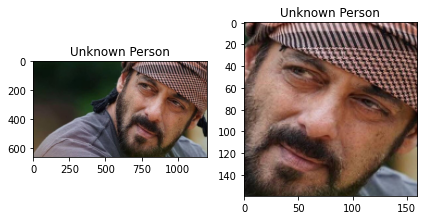

In [41]:
# Load a single test image
test_image_path = 'salman3.jpg'  # Replace 'image.jpg' with the actual file name and path

img = cv2.imread(test_image_path)[:,:,::-1]

test_image = extract_face(test_image_path)

# Convert the test image into embedding

emdTestX = get_embedding(facenet_model, test_image)
emdTestX = np.expand_dims(emdTestX, axis=0)

# prediction for the face
# Predict the label for the test image

yhat_class = model.predict(emdTestX)
predict_name = out_encoder.inverse_transform(yhat_class)

yhat_prob = model.predict_proba(emdTestX)

# get name

class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
all_names = out_encoder.inverse_transform([0,1,2,3,4])


if class_probability>30:
    print("This person is ",predict_name[0])
    
    title = '%s (%.3f)' % (predict_names[0], class_probability)
else:
    print("This person is ",round(class_probability,2),"% Similar to but Not Confirmed ",predict_name[0])
    title = ("Unknown Person")


fig, axs = plt.subplots(1, 2)

# Assign each image to a specific subplot
axs[0].imshow(img)
axs[0].set_title(title)

axs[1].imshow(test_image)
axs[1].set_title(title)


# Adjust the layout and display the figure
plt.tight_layout()
plt.show()


##  FACE RECOGNITION FOR MULTIPLE FACES

1/1 [==============================] - 0s 79ms/step
madonna
This person is 19.42 % Similar to but Not surely :   madonna


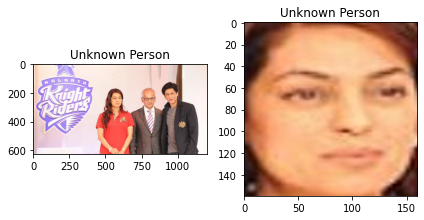

1/1 [==============================] - 0s 69ms/step
madonna
This person is 17.41 % Similar to but Not surely :   madonna


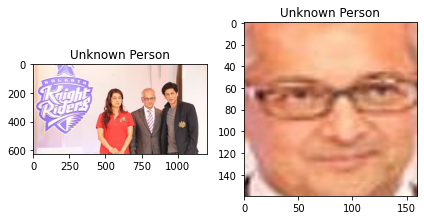

1/1 [==============================] - 0s 76ms/step
SRK
This person is SRK


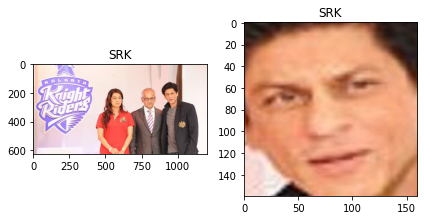

TOTAL FACES DETECTED :  3
Names of All the People Detected:  ['SRK']


In [39]:
# Load the test image
test_image_path = 'testing_data/srk3.jpg'  
img = cv2.imread(test_image_path)[:,:,::-1]
names = []

# Extract faces from the test image
test_faces = extract_faces(test_image_path)

total_faces = int(0)
# Loop over the extracted faces and perform face recognition
for test_face in test_faces:
    total_faces+=1
    # Convert the test face into embedding
    emdTestX = get_embedding(facenet_model, test_face)
    emdTestX = np.expand_dims(emdTestX, axis=0)
    

    # Predict the label for the test face
    yhat_class = model.predict(emdTestX)
    predict_name = out_encoder.inverse_transform(yhat_class)
    

    # Predict the probability for the test face
    yhat_prob = model.predict_proba(emdTestX)
    class_index = yhat_class[0]
    class_probability = yhat_prob[0, class_index] * 100
    predict_names = out_encoder.inverse_transform(yhat_class)
 
    n = predict_names[0]
    print(n)



    if class_probability > 30:
        print("This person is", predict_name[0])
#         title = '%s (%.3f)' % (predict_names[0], class_probability)
        title = n
        if n not in names:
            names.append(n)
    else:
        print("This person is", round(class_probability, 2), "% Similar to but Not surely :  ", predict_name[0])
        title = "Unknown Person"
    
    # Display the test face and predicted label
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(img)
    axs[0].set_title(title)
    axs[1].imshow(test_face)
    axs[1].set_title(title)
    plt.tight_layout()
    plt.show()
print("TOTAL FACES DETECTED : ",total_faces)
print("Names of All the People Detected: ",names)
